## 1. Configuración
Crearse una cuenta en Weights and Biases (o en su board favorito) y linkear la notebook a este. Cada experimento deberá contener nombres dicientes y almacenar los (hiper)parámetros de configuración del mismo. Deberá separar los sets de datos en entrenamiento, validación y test. Utilizando solamente los sets de entrenamiento y validación, registrar la loss en train y validación en cada iteración que considere conveniente

In [53]:
%pip install --pre torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/nightly/cpu


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/nightly/cpu
Note: you may need to restart the kernel to use updated packages.


In [31]:
%pip install scikit-learn wandb


Note: you may need to restart the kernel to use updated packages.


In [32]:
%pip install torchview torchviz graphviz


Note: you may need to restart the kernel to use updated packages.


In [54]:
import torch
import torch.utils.data
import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms

from torchview import draw_graph
from torchviz import make_dot

from sklearn.model_selection import train_test_split

import numpy as np
import matplotlib.pyplot as plt
import wandb

import ssl
import os
from tqdm import tqdm


In [55]:
# Como contamos con procesadores ARM M1, el backend para correr con la GPU es Metal, por lo que setiamos el device a MPS
device = torch.device(
    'mps:0' if torch.backends.mps.is_available() else 'cuda:0' if torch.cuda.is_available() else 'cpu'
    )

device


device(type='mps', index=0)

In [56]:
wandb.login()


True

In [57]:
ssl._create_default_https_context = ssl._create_unverified_context


In [58]:
# Chequeamos si la carpeta data existe, si no existe la creamos
download = not os.path.isdir('./data')


In [59]:
torch.manual_seed(181988)
if torch.cuda.is_available():
    torch.cuda.manual_seed(181988)


In [60]:
batch_size = 32

# Guardamos en la variable transform un tensor de 3 dimensiones (RGB) normalizado
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)


### Train Set y Validation Set

In [61]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable train_set
train_set = torchvision.datasets.CIFAR10(
    root="./data", train=True, download=download, transform=transform
)

# Guardamos en targets_ las etiquetas de las imágenes del dataset
targets_ = train_set.targets

# Dividimos el dataset en train y validation
train_idx, val_idx = train_test_split(
    np.arange(len(targets_)), test_size=0.2, stratify=targets_
)

# Creamos los samplers para train y validation
train_sampler = torch.utils.data.SubsetRandomSampler(train_idx)
val_sampler = torch.utils.data.SubsetRandomSampler(val_idx)

# Creamos los dataloaders para train y validation
train_loader = torch.utils.data.DataLoader(
    train_set, sampler=train_sampler, batch_size=batch_size, num_workers=2
)
val_loader = torch.utils.data.DataLoader(
    train_set, sampler=val_sampler, batch_size=batch_size, num_workers=2
)


### Test Set

In [62]:
# Descargamos el dataset CIFAR10 y lo guardamos en la variable test_set
test_set = torchvision.datasets.CIFAR10(
    root="./data", train=False, download=download, transform=transform
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=batch_size, shuffle=False, num_workers=2
)

classes = (
    "plane",
    "car",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
)


### Visualizacion de Imagenes

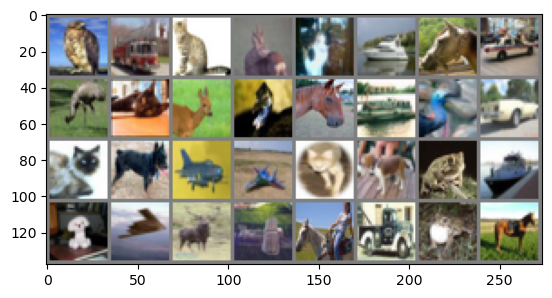

bird  truck cat   deer  cat   ship  horse car   bird  cat   deer  bird  horse ship  bird  car   cat   dog   plane plane cat   dog   frog  ship  dog   plane deer  plane horse truck frog  horse


torch.Size([3, 32, 32])

In [63]:
%matplotlib inline

# Funcion para mostrar imagenes
def imshow(img):
    img = img / 2 + 0.5     
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Tomar imagenes random
data_iter = iter(train_loader)
images, labels = next(data_iter)

# Mostramos imagenes
imshow(torchvision.utils.make_grid(images))

# Printeamos las etiquetas de las imagenes
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(batch_size)))

image_size = images[0].shape
image_size


## 2. Arquitectura
Realizar experimentos variando cantidad de capas densas, nodos, hidden layers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

### MPS Larger3 Softmax Dropout Relu

In [52]:
class Net1(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc1 = nn.Linear(32 * 32 * 3, 32 * 32 * 3)
        self.fc21 = nn.Linear(32 * 32 * 3, 32 * 32)
        self.d1 = nn.Dropout(0.2)
        self.fc22 = nn.Linear(32 * 32, 800)
        self.d2 = nn.Dropout(0.2)
        self.fc23 = nn.Linear(800, 360)
        self.fc24 = nn.Linear(360, 480)
        self.fc25 = nn.Linear(480, 240)
        self.fc26 = nn.Linear(240, 120)
        self.d3 = nn.Dropout(0.2)
        self.fc2 = nn.Linear(120, 90)
        self.fc3 = nn.Linear(90, 24)
        self.fc4 = nn.Linear(24, 10)

    def forward(self, x):
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc21(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc22(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc24(x))
        x = F.leaky_relu(self.fc25(x))
        x = F.leaky_relu(self.fc26(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        x = self.fc4(x)
        x = F.log_softmax(x, dim=1)
        return x

experiment_name = "MPS Larger3 Softmax Dropout Relu"
net = Net1()
net.to(device)


Net1(
  (fc1): Linear(in_features=3072, out_features=3072, bias=True)
  (fc21): Linear(in_features=3072, out_features=1024, bias=True)
  (d1): Dropout(p=0.2, inplace=False)
  (fc22): Linear(in_features=1024, out_features=800, bias=True)
  (d2): Dropout(p=0.2, inplace=False)
  (fc23): Linear(in_features=800, out_features=360, bias=True)
  (fc24): Linear(in_features=360, out_features=480, bias=True)
  (fc25): Linear(in_features=480, out_features=240, bias=True)
  (fc26): Linear(in_features=240, out_features=120, bias=True)
  (d3): Dropout(p=0.2, inplace=False)
  (fc2): Linear(in_features=120, out_features=90, bias=True)
  (fc3): Linear(in_features=90, out_features=24, bias=True)
  (fc4): Linear(in_features=24, out_features=10, bias=True)
)

### MPS LeakyRelu Dropout

In [80]:
class Net2(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.d1 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 128)
        self.d2 = nn.Dropout(0.4)
        self.fc5 = nn.Linear(128, 64)
        self.fc6 = nn.Linear(64, 32)
        self.d3 = nn.Dropout(0.4)
        self.fc7 = nn.Linear(32, 16)
        self.fc8 = nn.Linear(16, 8)
        self.d4 = nn.Dropout(0.4)
        self.fc9 = nn.Linear(8, 4)
        self.fc10 = nn.Linear(4, 2)
        self.d5 = nn.Dropout(0.4)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.d1(x)
        x = F.leaky_relu(self.fc3(x))
        x = F.leaky_relu(self.fc4(x))
        x = self.d2(x)
        x = F.leaky_relu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = self.d3(x)
        x = F.leaky_relu(self.fc7(x))
        x = F.leaky_relu(self.fc8(x))
        x = self.d4(x)
        x = F.leaky_relu(self.fc9(x))
        x = F.leaky_relu(self.fc10(x))
        x = self.d5(x)
        x = F.log_softmax(x, dim=1)
        return x

experiment_name = "MPS LeakyRelu Dropout"
net = Net2()
net.to(device)

Net2(
  (fc1): Linear(in_features=3072, out_features=1024, bias=True)
  (fc2): Linear(in_features=1024, out_features=512, bias=True)
  (d1): Dropout(p=0.4, inplace=False)
  (fc3): Linear(in_features=512, out_features=256, bias=True)
  (fc4): Linear(in_features=256, out_features=128, bias=True)
  (d2): Dropout(p=0.4, inplace=False)
  (fc5): Linear(in_features=128, out_features=64, bias=True)
  (fc6): Linear(in_features=64, out_features=32, bias=True)
  (d3): Dropout(p=0.4, inplace=False)
  (fc7): Linear(in_features=32, out_features=16, bias=True)
  (fc8): Linear(in_features=16, out_features=8, bias=True)
  (d4): Dropout(p=0.4, inplace=False)
  (fc9): Linear(in_features=8, out_features=4, bias=True)
  (fc10): Linear(in_features=4, out_features=2, bias=True)
  (d5): Dropout(p=0.4, inplace=False)
)

### MPS Relu ELU LeakyRelu

In [50]:
class Net3(nn.Module):
    def __init__(self):
        super().__init__()

        self.fc1 = nn.Linear(32 * 32 * 3, 512)
        self.d1 = nn.Dropout(0.3)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, 128)
        self.fc4 = nn.Linear(128, 10)
        self.d2 = nn.Dropout(0.3)
        self.fc5 = nn.Linear(64, 10)
        self.fc6 = nn.Linear(32, 10)
        self.fc7 = nn.Linear(16, 10)
        self.d3 = nn.Dropout(0.3)

    def forward(self, x):
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = self.d1(x)
        x = F.elu(self.fc2(x))
        x = F.leaky_relu(self.fc3(x))  
        x = self.fc4(x)
        x = self.d2(x)
        x = F.elu(self.fc5(x))
        x = F.leaky_relu(self.fc6(x))
        x = F.leaky_relu(self.fc7(x))
        x = self.d3(x)
        x = F.log_softmax(x, dim=1)
        return x

experiment_name = "MPS Relu ELU LeakyRelu"
net = Net3()
net.to(device)

Net3(
  (fc1): Linear(in_features=3072, out_features=512, bias=True)
  (d1): Dropout(p=0.3, inplace=False)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=10, bias=True)
  (d2): Dropout(p=0.3, inplace=False)
  (fc5): Linear(in_features=64, out_features=10, bias=True)
  (fc6): Linear(in_features=32, out_features=10, bias=True)
  (fc7): Linear(in_features=16, out_features=10, bias=True)
  (d3): Dropout(p=0.3, inplace=False)
)

In [ ]:
nn_model = Net()
x = torch.randn(1, 3, 32, 32)
y = nn_model(x)

make_dot(y, params=dict(nn_model.named_parameters()))

In [ ]:
nn_graph = draw_graph(nn_model, torch.zeros([1, 3, 32, 32]).to(device), expand_nested=True)
nn_graph.visual_graph


## 3. Arquitectura CNN
Extienda el análisis utilizando capas convolucionales y reportar el mejor y peor experimento. ¿Cómo se compara?

### NetConv

In [ ]:
class NetConv(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc21 = nn.Linear(120, 120)
        self.fc22 = nn.Linear(120, 120)
        self.fc23 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.leaky_relu(self.conv1(x)))
        x = self.pool(F.leaky_relu(self.conv2(x)))
        x = torch.flatten(x, 1)  # flatten all dimensions except batch
        x = F.leaky_relu(self.fc1(x))
        x = F.leaky_relu(self.fc21(x))
        x = F.leaky_relu(self.fc22(x))
        x = F.leaky_relu(self.fc23(x))
        x = F.leaky_relu(self.fc2(x))
        x = self.fc3(x)
        return x


experiment_name = "MPS Conv LeakyRelu"
net = NetConv()
net.to(device)


NetConv(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc21): Linear(in_features=120, out_features=120, bias=True)
  (fc22): Linear(in_features=120, out_features=120, bias=True)
  (fc23): Linear(in_features=120, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
conv_net_model = NetConv()
x = torch.randn(1, 3, 32, 32)

make_dot(conv_net_model(x), params=dict(conv_net_model.named_parameters()))


In [ ]:
convnet_graph = draw_graph(conv_net_model, torch.zeros([1, 3, 32, 32]).to(device), expand_nested=True)
convnet_graph.visual_graph


### VGG16

In [ ]:
class VGG16(nn.Module):
    def __init__(self, num_classes=10):
        super(VGG16, self).__init__()

        self.transform = transforms.Compose(
            [
                transforms.Resize((224, 224)),
                transforms.ToTensor(), 
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
            ]
        )
        
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU())
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(), 
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(128, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer6 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer7 = nn.Sequential(
            nn.Conv2d(256, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer8 = nn.Sequential(
            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer9 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer10 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.layer11 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer12 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU())
        self.layer13 = nn.Sequential(
            nn.Conv2d(512, 512, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 2, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(7*7*512, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)
        x = self.layer8(x)
        x = self.layer9(x)
        x = self.layer10(x)
        x = self.layer11(x)
        x = self.layer12(x)
        x = self.layer13(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x


experiment_name = "VGG16 BatchSize 10"
net = VGG16()
net.to(device)

# Apply net.transform to all images in train_loader, test_loader, val_loader

train_loader.dataset.transform = net.transform
test_loader.dataset.transform = net.transform
val_loader.dataset.transform = net.transform


In [ ]:
model = VGG16()
model = model.to(device)

dataiter = iter(test_loader)
data = next(dataiter)
test_images, test_labels = data[0].to(device), data[1].to(device)

x = test_images[0]
x = x.to(device)
x = x.unsqueeze(0)

make_dot(model(x), params=dict(model.named_parameters()))


In [ ]:
fig, ax = plt.subplots(figsize=(20, 20))

vgg16_graph = draw_graph(model, test_images, expand_nested=True)
vgg16_graph.visual_graph.save('plots/vgg16_graph.png')
vgg16_graph.visual_graph

# Set title
ax.set_title("VGG16 Graph")


### InceptionNet
Para este modelo, lo scamos de https://www.kaggle.com/code/mohamedmustafa/10-implement-inceptionnet-from-scratch-pytorch y lo modificamos para que se adapte a nuestro codigo.

In [85]:
class ConvBlock(nn.Module):
    def __init__(self, In_Channels, Out_Channels, Kernel_Size, Stride, Padding):
        super(ConvBlock, self).__init__()
        self.Conv = nn.Conv2d(in_channels=In_Channels, out_channels=Out_Channels, kernel_size=Kernel_Size, stride=Stride, padding=Padding)
        self.Batch_Norm = nn.BatchNorm2d(num_features=Out_Channels)
        self.Activ_Func = nn.ReLU()
    
    """
    Ahora construiremos la función forward que define el camino hacia el tensor de entrada dandole a entender al tensor la secuencia de capas que se está atravesando
    """
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Batch_Norm(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        
        return Tensor_Path

In [86]:
class InceptionBlock(nn.Module):
    def __init__(self,In_Channels, Num_Of_Filters_1x1, Num_Of_Filters_3x3, Num_Of_Filters_5x5, Num_Of_Filters_3x3_Reduce,Num_Of_Filters_5x5_Reduce, Pooling):
        super(InceptionBlock, self).__init__()
        # The In_Channels are the depth of tensor coming from previous layer
        # First block contains only filters with kernel size 1x1
        self.Block_1 = nn.Sequential(ConvBlock(In_Channels=In_Channels, Out_Channels=Num_Of_Filters_1x1, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)))
        
        # Second Block contains filters with kernel size 1x1 followed by 3x3
        self.Block_2 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_3x3_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_3x3_Reduce, Out_Channels= Num_Of_Filters_3x3, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        )
        
        # Third Block same as second block unless we'll replace the 3x3 filter with 5x5 
        self.Block_3 = nn.Sequential(
            ConvBlock(In_Channels=In_Channels, Out_Channels= Num_Of_Filters_5x5_Reduce, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0)),
            ConvBlock(In_Channels=Num_Of_Filters_5x5_Reduce, Out_Channels= Num_Of_Filters_5x5, Kernel_Size=(5,5), Stride=(1,1), Padding=(2,2))
        )
        
        # Fourth Block contains maxpooling layer followed by 1x1 filter
        self.Block_4 = nn.Sequential(
            nn.MaxPool2d(kernel_size=(3,3), stride=(1,1), padding=(1,1)),
            ConvBlock(In_Channels=In_Channels, Out_Channels=Pooling, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        )
    def forward(self, Tensor_Path):
        First_Block_Out = self.Block_1(Tensor_Path)
        Second_Block_Out = self.Block_2(Tensor_Path)
        Third_Block_Out = self.Block_3(Tensor_Path)
        Fourth_Block_Out = self.Block_4(Tensor_Path)
        
        Concatenated_Outputs = torch.cat([First_Block_Out,Second_Block_Out, Third_Block_Out, Fourth_Block_Out], dim=1) #dim=1 because we want to concatenate in the depth dimension
        return Concatenated_Outputs

In [87]:
class Auxiliary_Classifier(nn.Module):
    def __init__(self, In_Channels, Num_Classes):
        super(Auxiliary_Classifier, self).__init__()
        self.Adaptive_AvgPool = nn.AdaptiveAvgPool2d(output_size=(4, 4))
        self.Conv = nn.Conv2d(in_channels= In_Channels, out_channels=128, kernel_size=(1,1), stride=(1,1), padding=(0,0))
        self.Activ_Func = nn.ReLU()
        # in_features=2048 because we should flatten the input tensor which has shape of (batch, 4,4,128) so after flaten the tensor will be (batch, 4*4*128)
        # out_features=1024 this number from paper
        self.FC_1 = nn.Linear(in_features=2048, out_features=1024) 
        self.DropOut = nn.Dropout(p=0.7) 
        self.FC_2 = nn.Linear(in_features=1024, out_features= Num_Classes)
    
    def forward(self, Tensor_Path):
        Tensor_Path = self.Adaptive_AvgPool(Tensor_Path)
        Tensor_Path = self.Conv(Tensor_Path)
        Tensor_Path = self.Activ_Func(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.FC_1(Tensor_Path)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC_2(Tensor_Path)
        
        return Tensor_Path

In [95]:
class InceptionNet_V1(nn.Module):
    def __init__(self, Out_Classes):
        super(InceptionNet_V1, self).__init__()
        self.Conv_1 = ConvBlock(In_Channels=3, Out_Channels=64, Kernel_Size=(7,7), Stride=(2,2), Padding=(3,3))
        self.MaxPool_1 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Conv_2 = ConvBlock(In_Channels=64, Out_Channels=64, Kernel_Size=(1,1), Stride=(1,1), Padding=(0,0))
        self.Conv_3 = ConvBlock(In_Channels=64, Out_Channels=192, Kernel_Size=(3,3), Stride=(1,1), Padding=(1,1))
        self.MaxPool_2 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_3a = InceptionBlock(In_Channels=192, Num_Of_Filters_1x1=64, Num_Of_Filters_3x3=128
                                          , Num_Of_Filters_5x5=32, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=32)
        
        self.Inception_3b = InceptionBlock(In_Channels=256, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=192
                                          , Num_Of_Filters_5x5=96, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64)
        
        self.MaxPool_3 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_4a = InceptionBlock(In_Channels=480, Num_Of_Filters_1x1=192, Num_Of_Filters_3x3=208
                                          , Num_Of_Filters_5x5=48, Num_Of_Filters_3x3_Reduce=96, 
                                           Num_Of_Filters_5x5_Reduce=16, Pooling=64)
        
        self.Inception_4b = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=160, Num_Of_Filters_3x3=224
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=112, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
        
        self.Inception_4c = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=128, Num_Of_Filters_3x3=256
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=128, 
                                           Num_Of_Filters_5x5_Reduce=24, Pooling=64)
        
       
        self.Inception_4d = InceptionBlock(In_Channels=512, Num_Of_Filters_1x1=112, Num_Of_Filters_3x3=288
                                          , Num_Of_Filters_5x5=64, Num_Of_Filters_3x3_Reduce=144, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=64) 
        
        self.Inception_4e = InceptionBlock(In_Channels=528, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.MaxPool_4 = nn.MaxPool2d(kernel_size=(3,3), stride=(2,2), padding=(0,0), ceil_mode=True)
        self.Inception_5a = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=256, Num_Of_Filters_3x3=320
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=160, 
                                           Num_Of_Filters_5x5_Reduce=32, Pooling=128) 
        
        self.Inception_5b = InceptionBlock(In_Channels=832, Num_Of_Filters_1x1=384, Num_Of_Filters_3x3=384
                                          , Num_Of_Filters_5x5=128, Num_Of_Filters_3x3_Reduce=192, 
                                           Num_Of_Filters_5x5_Reduce=48, Pooling=128) 
        
        self.AvgPool_1 = nn.AdaptiveAvgPool2d(output_size=(1,1))
        self.DropOut = nn.Dropout(p=0.4)
        self.FC = nn.Linear(in_features=1024, out_features=Out_Classes)
        
        self.Auxiliary_4a = Auxiliary_Classifier(In_Channels=512, Num_Classes=Out_Classes)
        self.Auxiliary_4d = Auxiliary_Classifier(In_Channels=528, Num_Classes=Out_Classes)
        
    def forward(self, Tensor_Path):
        Tensor_Path = self.Conv_1(Tensor_Path)
        Tensor_Path = self.MaxPool_1(Tensor_Path)
        Tensor_Path = self.Conv_2(Tensor_Path)
        Tensor_Path = self.Conv_3(Tensor_Path)
        Tensor_Path = self.MaxPool_2(Tensor_Path)
        Tensor_Path = self.Inception_3a(Tensor_Path)
        Tensor_Path = self.Inception_3b(Tensor_Path)
        Tensor_Path = self.MaxPool_3(Tensor_Path)
        Tensor_Path = self.Inception_4a(Tensor_Path)
        Auxiliary_1 = self.Auxiliary_4a(Tensor_Path)
        Tensor_Path = self.Inception_4b(Tensor_Path)
        Tensor_Path = self.Inception_4c(Tensor_Path)
        Tensor_Path = self.Inception_4d(Tensor_Path)
        Auxiliary_2 = self.Auxiliary_4d(Tensor_Path)
        Tensor_Path = self.Inception_4e(Tensor_Path)
        Tensor_Path = self.MaxPool_4(Tensor_Path)
        Tensor_Path = self.Inception_5a(Tensor_Path)
        Tensor_Path = self.Inception_5b(Tensor_Path)
        Tensor_Path = self.AvgPool_1(Tensor_Path)
        Tensor_Path = torch.flatten(Tensor_Path, 1)
        Tensor_Path = self.DropOut(Tensor_Path)
        Tensor_Path = self.FC(Tensor_Path)
        
        return Tensor_Path, Auxiliary_1, Auxiliary_2

## 4. Funciones de activación
Realizar experimentos variando distintas funciones de activación y reportar el mejor y peor experimento. Explicar.

## 5. Optimizadores
Realizar experimentos evaluando distintos optimizadores, schedulers y reportar el mejor y peor experimento. ¿Qué estrategia utilizaron? ¿Qué resultados obtuvieron?

In [100]:
## Parámetros de entrenamiento
learning_rate = 0.01
momentum = 0.4
epochs = 10


In [81]:
# Optimizador y función de pérdida
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(
    net.parameters(),
    lr=learning_rate,
    momentum=momentum
)

## 6. Entrenamiento
Realizar experimentos evaluando distintos batch-sizes, epochs y reportar el mejor y peor experimento. ¿Qué resultados obtuvieron?

### Definicion nombres

#### Experimentos que no son InsertionNet

In [82]:
# Nombre del experimento
project_name = "TP3"
experiment_name += " " + optimizer.__class__.__name__
experiment_name


'MPS LeakyRelu Dropout SGD'

#### Nombre de InsertionNet

In [101]:
experiment_name = "InceptionNetV1"
project_name = "TP3"

In [102]:
wandb.finish()
wandb.init(
    # seteamos el projecto donde se va a guardar el experimento en wandb
    project=project_name,
    name=experiment_name,
    
    # trackeamos los hiperparámetros y las métricas
    config={
        "learning_rate": learning_rate,
        "momentum": momentum,
        "batch_size": batch_size,
        "epochs": epochs,
    },
)


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


### Entrenamientos

#### Entrenamiento para InceptionNet

In [103]:
def Train_Validate_InceptionV1(Model, Train_Loader, Val_Loader, Num_Of_Train_Samples, Num_Of_Val_Samples, Criterion,Optimizer, Num_Epochs):
    # --------------------------------- TRAIN SET -----------------------------#
    
    # La accuracy y la loss de train y validation se guardan en estas listas por epoch
    Train_Loss_History = []
    Train_Accuracy_History = []
    Val_Loss_History = []
    Val_Accuracy_History = []
    iterator = tqdm(
        range(Num_Epochs),
        total=epochs,
        desc="Epoch"
    )
    for epoch in iterator:

        Num_Of_Predicted_Correctly = 0 # numero de predicciones correctas
        Train_Cummulative_Loss = 0 # suma de las loss de cada batch
        
        for batch_samples,targets in Train_Loader:
            batch_samples = batch_samples.to(device=device)
            targets = targets.to(device=device)
            
            # pasa las muestras de train por la red (Forward Path)
            Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)
            
            # Network Loss contiene la loss promedio de cada batch
            Network_Loss = Criterion(Network_Predictions, targets)
            Aux_1_Loss = Criterion(Aux_1_Predictions, targets)
            Aux_2_Loss = Criterion(Aux_2_Predictions, targets)
            
            # Pondera las losses de cada bloque de la red como dice el paper
            Main_Loss = Network_Loss + (0.3 * Aux_1_Loss) + (0.3 * Aux_2_Loss)
            
            # Backward Propagation
            Optimizer.zero_grad() # gradientes a cero
            Main_Loss.backward() # backpropagation
            Optimizer.step() # actualizacion de pesos
            
            _, Train_Samples_Predictions = Network_Predictions.max(1)
            Train_Samples_Predictions = Train_Samples_Predictions.to(device=device)
            Num_Of_Predicted_Correctly += (Train_Samples_Predictions == targets).float().sum().item()
            Train_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
        Train_Cummulative_Loss /= Num_Of_Train_Samples
        Train_Loss_History.append(Train_Cummulative_Loss)
        Train_Accuracy = 100 * Num_Of_Predicted_Correctly / Num_Of_Train_Samples
        Train_Accuracy_History.append(Train_Accuracy)
    
    #----------------------------- VALIDATION SET -----------------------------#
    
        Num_Of_Predicted_Correctly = 0
        with torch.no_grad(): # Como estamos en validacion no necesitamos calcular los gradientes
            Val_Cummulative_Loss = 0
            for batch_samples,targets in Val_Loader:
                batch_samples = batch_samples.to(device=device)
                targets = targets.to(device=device)

                # psamos los samples de validacion por la red (Forward Path)
                Network_Predictions, Aux_1_Predictions, Aux_2_Predictions = Model(batch_samples)

                # Network loss guarda la loss promedio de cada batch
                Network_Loss = Criterion(Network_Predictions, targets)
                Aux_1_Loss = Criterion(Aux_1_Predictions, targets)
                Aux_2_Loss = Criterion(Aux_2_Predictions, targets)

                # Pondera las losses de cada bloque de la red como dice el paper
                Main_Loss = Network_Loss + (0.3 * Aux_1_Loss) + (0.3 * Aux_2_Loss)

                _, Val_Samples_Predictions = Network_Predictions.max(1)
                Val_Samples_Predictions = Val_Samples_Predictions.to(device=device)
                Num_Of_Predicted_Correctly += (Val_Samples_Predictions == targets).float().sum().item()
                Val_Cummulative_Loss += Main_Loss.data.item() * batch_samples.shape[0]
            
            Val_Cummulative_Loss /= Num_Of_Val_Samples
            Val_Loss_History.append(Val_Cummulative_Loss)
            Val_Accuracy = 100 * Num_Of_Predicted_Correctly / Num_Of_Val_Samples
            Val_Accuracy_History.append(Val_Accuracy)
                    
            wandb.log(
                {
                    "train_accuracy": Train_Accuracy,
                    "val_accuracy": Val_Accuracy,
                    "train_loss": Train_Cummulative_Loss,
                    "val_loss": Val_Cummulative_Loss,
                }
            )

            iterator.set_postfix(
                {
                    "train_accuracy": Train_Accuracy,
                    "val_accuracy": Val_Accuracy,
                    "train_loss": Train_Cummulative_Loss,
                    "val_loss": Val_Cummulative_Loss,
                }
            )
        
    torch.save(Model.state_dict(), "InceptionNet_Model")
    return Train_Accuracy_History, Val_Accuracy_History, Train_Loss_History, Val_Loss_History

def Propagate_Network():
    Inception_Model = InceptionNet_V1(Out_Classes=10).to(device=device)
    Cross_Entropy_Criterion = nn.CrossEntropyLoss()
    Adam_Optimizer = optim.Adam(Inception_Model.parameters(), lr=0.001)

    Train_Validate_InceptionV1(
        Model = Inception_Model, 
        Train_Loader = train_loader,
        Val_Loader = val_loader,
        Num_Of_Train_Samples = 40000,
        Num_Of_Val_Samples = 10000,
        Criterion = Cross_Entropy_Criterion,
        Optimizer = Adam_Optimizer,
        Num_Epochs = epochs
    )
Propagate_Network()

wandb.finish()

Epoch:   0%|          | 0/10 [01:26<?, ?it/s]


KeyboardInterrupt: 

Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.

In [ ]:
PATH = './cifar_vgg_16_net.pth'
torch.save(net.state_dict(), PATH)

#### Entrenamiento para todas las demas estructuras

In [84]:
try:
    iterator = tqdm(
        range(epochs),
        total=epochs,
        desc="Epoch"
    )

    for epoch in iterator:
        
        # ---------------- SECCION DE TRAIN -----------------

        running_loss = 0.0
        train_correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):

            # Los datos son una lista de [inputs, labels]
            # inputs, labels = data
            inputs, labels = data[0].to(device), data[1].to(device)

            # Reiniciamos gradientes
            optimizer.zero_grad()

            # forward + backward + optimize

            outputs = net(inputs) # forward
            loss = criterion(outputs, labels) # perdida
            loss.backward() # backward
            optimizer.step() # optimizacion

            # print statistics
            running_loss += loss.item()
            # if i % 200 == 199:  # print every 200 mini-batches
            #    print(f"[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}")

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            iterator.set_postfix(
                {
                    "train_accuracy": 100 * train_correct / total,
                    "train_loss": running_loss / total,
                }
            )

        
        # ---------------- SECCION DE VALIDACION ----------------
        
        train_accuracy = 100 * train_correct / total
        running_loss = running_loss / total

        val_correct = 0
        total = 0
        val_loss = 0
        
        # Esta parte es sólo validación, no requiere entrenar, por lo que no calculamos gradientes.
        with torch.no_grad():
            for data in val_loader:
                images, labels = data[0].to(device), data[1].to(device)
                
                # Calculamos las salidas de la red para las imágenes de validación
                outputs = net(images)
                
                # La clase con mayor valor de salida es la predicción de la red
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                val_correct += (predicted == labels).sum().item()
                val_loss += criterion(outputs, labels).item()

        # Fin de la validación

        val_accuracy = 100 * val_correct / total
        val_loss = val_loss / total

        wandb.log(
            {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_loss": running_loss,
                "val_loss": val_loss,
            }
        )

        iterator.set_postfix(
            {
                "train_accuracy": train_accuracy,
                "val_accuracy": val_accuracy,
                "train_loss": running_loss,
                "val_loss": val_loss,
            }
        )

    print("Finished Training")
except Exception as e:
    print(e)
finally:
    wandb.finish()


Epoch:  40%|████      | 4/10 [05:16<07:54, 79.08s/it, train_accuracy=9.93, val_accuracy=10.3, train_loss=0.00433, val_loss=0.00434]


wandb: WARNING Source type is set to 'repo' but some required information is missing from the environment. A job will not be created from this run. See https://docs.wandb.ai/guides/launch/create-job


train_accuracy,▃█▅▁
train_loss,█▁▁▂
val_accuracy,▁▇▇█
val_loss,▃▁▁█
train_accuracy,9.9325
train_loss,0.00433
val_accuracy,10.27
val_loss,0.00434


KeyboardInterrupt: 

In [26]:
wandb.finish()


wandb: ERROR Dropped streaming file chunk (see wandb/debug-internal.log)


Ejemplo de guardar el modelo. Sin embargo lo deberiamos guardar para el que mejor dio en validation.

In [17]:
PATH = './cifar_vgg_16_net.pth'
torch.save(net.state_dict(), PATH)


## 7. Regularización
Evaluar alguna(s) técnica(s) de regularización. ¿Qué resultados obtuvieron?

## 8. Evaluación final
Evaluar el mejor modelo, es decir, el mejor de los ejercicios anteriores, con el set de test.

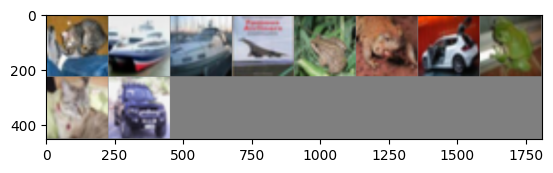

GroundTruth:  cat   ship  ship  plane frog  frog  car   frog  cat   car  
Predicted:  dog   ship  ship  ship 
Accuracy of the network on the 10000 test test_images: 67 %
Accuracy for class: plane is 73.5 %
Accuracy for class: car   is 88.1 %
Accuracy for class: bird  is 42.3 %
Accuracy for class: cat   is 56.7 %
Accuracy for class: deer  is 65.6 %
Accuracy for class: dog   is 49.7 %
Accuracy for class: frog  is 80.2 %
Accuracy for class: horse is 78.8 %
Accuracy for class: ship  is 83.2 %
Accuracy for class: truck is 65.3 %


In [23]:
#net = Net()
#net.load_state_dict(torch.load(PATH))

dataiter = iter(test_loader)
data = next(dataiter)
test_images, test_labels = data

# print test_images
imshow(torchvision.utils.make_grid(test_images))
print("GroundTruth: ", " ".join(f"{classes[test_labels[j]]:5s}" for j in range(batch_size)))

test_images, test_labels = data[0].to(device), data[1].to(device)
outputs = net(test_images)
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join(f'{classes[predicted[j]]:5s}'
                              for j in range(4)))

correct = 0
total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        # calculate outputs by running test_images through the network
        outputs = net(test_images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += test_labels.size(0)
        correct += (predicted == test_labels).sum().item()

print(f"Accuracy of the network on the 10000 test test_images: {100 * correct // total} %")

# prepare to count predictions for each class
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}

# again no gradients needed
with torch.no_grad():
    for data in test_loader:
        test_images, test_labels = data[0].to(device), data[1].to(device)
        outputs = net(test_images)
        _, predictions = torch.max(outputs, 1)
        # collect the correct predictions for each class
        for label, prediction in zip(test_labels, predictions):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1


# print accuracy for each class
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print(f"Accuracy for class: {classname:5s} is {accuracy:.1f} %")
